### Generation of showers with CaloGAN per 10 Epoch

#### Environment setup in maxwell
 --- login to max-display002 -- 
  
   - `module load anaconda/3`
   - `conda create --name mypy37 python=3.7 # chose your own python version!`
   - `conda init bash`
   - `conda activate mypy3`
   - `pip install uncertainties # and other modules, as needed`
   - `pip install ipykernel`
   - `pip install scikit-learn`
   - `python -m ipykernel install --user --name mypy37 --display-name "My Py3.7"`
  

In [1]:
import keras
from keras.layers import Input, Lambda, Activation, AveragePooling2D, UpSampling2D
from keras.models import Model
from keras.layers.merge import multiply
import keras.backend as K

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm

latent_size = 1024
%cd /home/eren/CaloGAN/models/
from architectures import build_generator, build_discriminator, sparse_softmax
from ops import scale, inpainting_attention
%cd -

from scipy import stats
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

from feats1d import *
plt.rcParams.update({'font.size': 20})
colors = plt.cm.gnuplot2(np.linspace(0.2, 0.8, 3))



Using TensorFlow backend.


/home/eren/CaloGAN/models
/home/eren/CaloGAN/analysis


In [2]:
import h5py
g = h5py.File('/home/eren/CaloGAN/data/gamma50GeV.hdf5', 'r')

## Loading Geant4 images
gamma = []
for j in range(5): 
    gamma.append(g['layer_{}'.format(j)][:75000])


vmin = [ gamma[k].mean(axis=0).min() for k in range(5)]
vmax = [ gamma[k].mean(axis=0).max() for k in range(5) ]

sizes = [gamma[0].shape[1], gamma[0].shape[2]] * 5

real_images_gamma = [gamma[k] for k in range(5)]

In [ ]:
%ls /home/eren/CaloGAN/data | grep generator | grep EUniform | grep 050 > ~/epochW.txt

In [3]:
with open('/home/eren/epochW.txt', 'r') as f:
    epochs = [line.strip() for line in f]

In [4]:
epochs

['params_generator-Eph150-5lay-EUniform-Hyp_Bs256_L005_nomLR050.hdf5']

In [ ]:
for i in epochs:
    print (i.split('_')[-1][5:8])

In [5]:
# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [6]:
### Get Geant4 images for fixed energy
def g4fixed(e):
    energy = g['energy'][:]
    idx = np.where( (energy > (e - 0.5)) & (energy < (e + 0.5)) )
    gamma = []
    for j in range(5): 
        tmp = g['layer_{}'.format(j)][:]
        gamma.append(tmp[idx[0]])
    return gamma

In [ ]:
t = g4fixed(25)
t[0].shape[0]

In [ ]:
gamma[0].shape

### Showers with variable energy 









Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
z (InputLayer)                  (None, 1024)         0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1024)         0           z[0][0]                          
                                                                 lambda_2[0][0]     

75000/75000 [==============================] - 291s 4ms/step


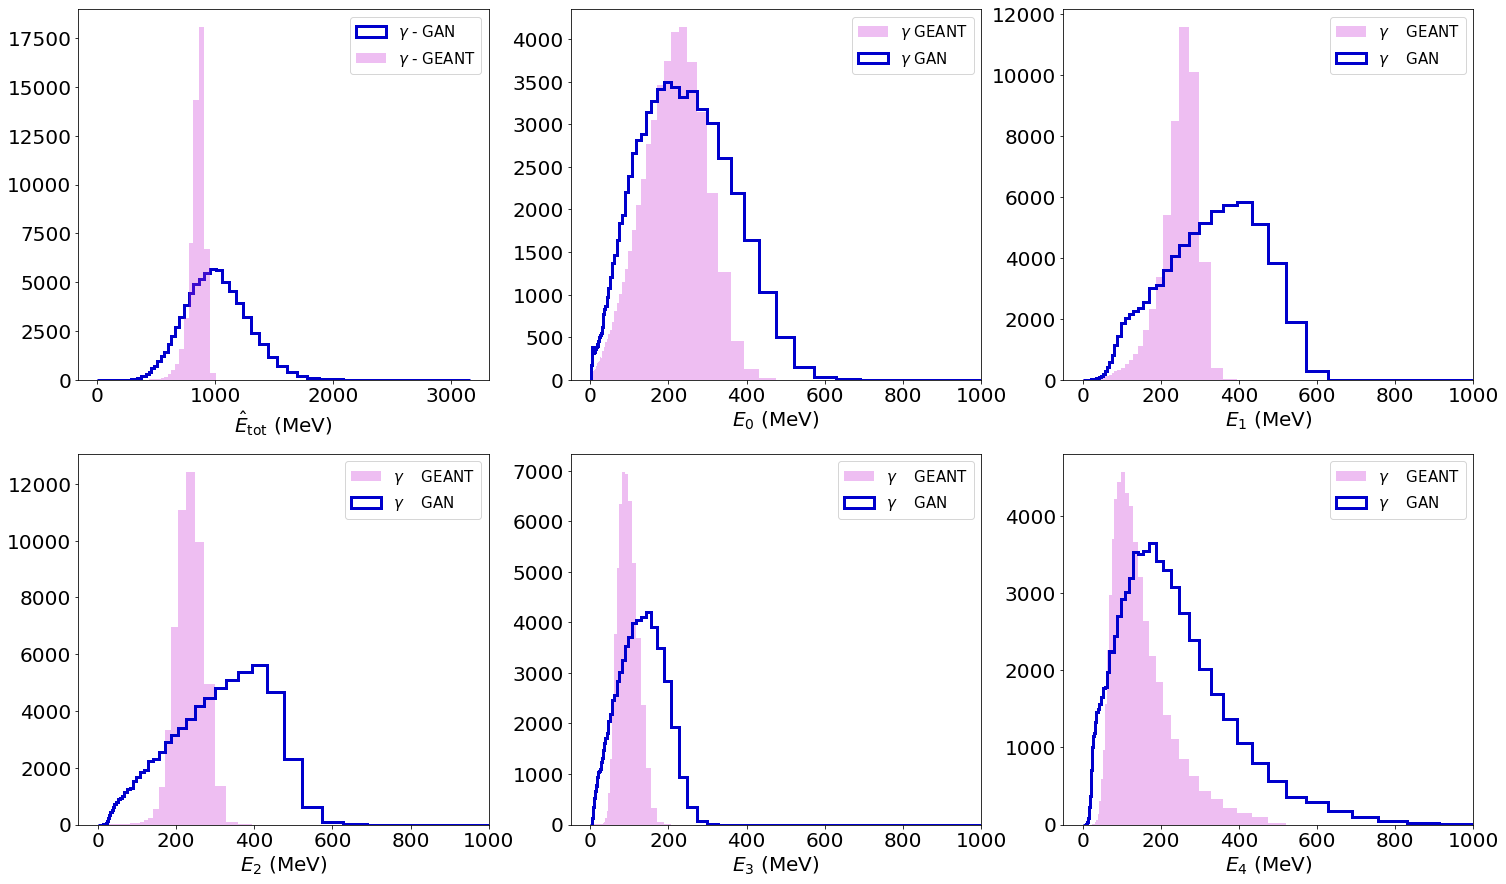

In [7]:
plt.rcParams.update({'font.size': 20})
colors = plt.cm.gnuplot2(np.linspace(0.2, 0.8, 3))

etotGenList = []
etotG4List = []


for eph in epochs:
    
    # input placeholders
    latent = Input(shape=(latent_size, ), name='z') # noise
    input_energy = Input(shape=(1, ), dtype='float32') # requested energy of the particle shower
    generator_inputs = [latent, input_energy]

    # multiply the (scaled) energy into the latent space
    h = Lambda(lambda x: x[0] * x[1])([latent, scale(input_energy, 100)])

    # build 5 LAGAN-style generators (checkout out `build_generator` in architectures.py)
    img_layer = []
    for i in range(5):
        img_layer.append(build_generator(h, 12, 12))

    # inpainting
    zero2one = AveragePooling2D(pool_size=(1, 1))(UpSampling2D(size=(1, 1))(img_layer[0]))
    img_layer[1] = inpainting_attention(img_layer[1], zero2one)
    for j in range(1,4):
        one2N = AveragePooling2D(pool_size=(1, 1))(img_layer[j])
        img_layer[j+1] = inpainting_attention(img_layer[j+1], one2N)

    generator_outputs = []

    ## outputs
    for k in range(5):
        generator_outputs.append(Activation('relu')(img_layer[k]))
        

    # build the actual model
    generator = Model(generator_inputs, generator_outputs)
    # load trained weights
    generator.load_weights('/home/eren/CaloGAN/data/{}'.format(eph))
    # 75,000 is the number of showers we want to generate right now
    noise = np.random.normal(0, 1, (75000, latent_size))
    sampled_energy = np.random.uniform(10, 100, (75000, 1))
    
    print (generator.summary())
    #sampled_energy25 = np.random.uniform(25, 25, (30000, 1))
    #sampled_energy75 = np.random.uniform(75, 75, (30000, 1))

    images = generator.predict([noise, sampled_energy], verbose=True)
    # we need to multiply images by 1000 to match order of magnitude of generated images to real images
    ## watch out for python3 changes: map method doesnt return list!
    images = list(map(lambda x: np.squeeze(x * 1000), images))
    
    
    dgen_gamma = {
    'layer_0': np.squeeze(images[0]),
    'layer_1': np.squeeze(images[1]),
    'layer_2': np.squeeze(images[2]),
    'layer_3': np.squeeze(images[3]),
    'layer_4': np.squeeze(images[4])
    }
    
    etot_gen_gamma = total_energy(dgen_gamma)
    etot_orig_gamma = total_energy(g)
    
    e0_orig_gamma = energy('0', g)
    e0_gen_gamma = energy('0', dgen_gamma)

    e1_orig_gamma = energy('1', g)
    e1_gen_gamma = energy('1', dgen_gamma)

    e2_orig_gamma = energy('2', g)
    e2_gen_gamma = energy('2', dgen_gamma)

    e3_orig_gamma = energy('3', g)
    e3_gen_gamma = energy('3', dgen_gamma)

    e4_orig_gamma = energy('4', g)
    e4_gen_gamma = energy('4', dgen_gamma)
    bins = np.linspace(0, 3000, 200)
        
    fig, axs = plt.subplots(2, 3, figsize=(25, 15))
    
   
    
    _ = axs[0][0].hist(etot_gen_gamma, bins=np.logspace(-1, 3.5, 200), histtype='step', linewidth=3,
             alpha=1, color=colors[0],
             label=r'$\gamma$ - GAN')

    _ = axs[0][0].hist(etot_orig_gamma, bins=np.logspace(-1, 3.5, 200), histtype='stepfilled', linewidth=3,
             alpha=0.3, color=colors[1],
             label=r'$\gamma$ - GEANT')
    axs[0][0].set_xlabel(r'$\hat{E}_\mathrm{tot}$ (MeV)')
    axs[0][0].legend(loc='upper right', fontsize=15, ncol=1)
    
    
    etotGenList.append(etot_gen_gamma)
    etotG4List.append(etot_orig_gamma)

    


    _ = axs[0][1].hist(e0_orig_gamma, bins=np.logspace(-1, 3, 100), histtype='stepfilled', linewidth=3,
             alpha=0.3, color=colors[1],
             label=r'$\gamma$ GEANT')
    _ = axs[0][1].hist(e0_gen_gamma, bins=np.logspace(-1, 3, 100), histtype='step', linewidth=3,
             alpha=1, color=colors[0],
             label=r'$\gamma$ GAN')
    
    axs[0][1].set_xlabel(r'$E_0$ (MeV)')
    axs[0][1].legend(loc='upper right', fontsize=15, ncol=1)
    axs[0][1].set_xlim(xmax=1000)
    
    _ = axs[0][2].hist(e1_orig_gamma, bins=np.logspace(-1, 3, 100), histtype='stepfilled', linewidth=3,
             alpha=0.3, color=colors[1],
             label=r'$\gamma$    GEANT')
    _ = axs[0][2].hist(e1_gen_gamma, bins=np.logspace(-1, 3, 100), histtype='step', linewidth=3,
             alpha=1, color=colors[0],
             label=r'$\gamma$    GAN')
    
    axs[0][2].set_xlabel(r'$E_1$ (MeV)')
    axs[0][2].legend(loc='upper right', fontsize=15, ncol=1)
    axs[0][2].set_xlim(xmax=1000)
    
    _ = axs[1][0].hist(e2_orig_gamma, bins=np.logspace(-1, 3, 100), histtype='stepfilled', linewidth=3,
             alpha=0.3, color=colors[1],
             label=r'$\gamma$    GEANT')
    _ = axs[1][0].hist(e2_gen_gamma, bins=np.logspace(-1, 3, 100), histtype='step', linewidth=3,
             alpha=1, color=colors[0],
             label=r'$\gamma$    GAN')

    axs[1][0].set_xlabel(r'$E_2$ (MeV)')
    axs[1][0].legend(loc='upper right', fontsize=15, ncol=1)
    axs[1][0].set_xlim(xmax=1000)
    
    _ = axs[1][1].hist(e3_orig_gamma, bins=np.logspace(-1, 3, 100), histtype='stepfilled', linewidth=3,
             alpha=0.3, color=colors[1],
             label=r'$\gamma$    GEANT')
    _ = axs[1][1].hist(e3_gen_gamma, bins=np.logspace(-1, 3, 100), histtype='step', linewidth=3,
             alpha=1, color=colors[0],
             label=r'$\gamma$    GAN')
    
    axs[1][1].set_xlabel(r'$E_3$ (MeV)')
    axs[1][1].legend(loc='upper right', fontsize=15, ncol=1)
    axs[1][1].set_xlim(xmax=1000)
    
    _ = axs[1][2].hist(e4_orig_gamma, bins=np.logspace(-1, 3, 100), histtype='stepfilled', linewidth=3,
             alpha=0.3, color=colors[1],
             label=r'$\gamma$    GEANT')
    _ = axs[1][2].hist(e4_gen_gamma, bins=np.logspace(-1, 3, 100), histtype='step', linewidth=3,
             alpha=1, color=colors[0],
             label=r'$\gamma$    GAN')

    axs[1][2].set_xlabel(r'$E_4$ (MeV)')
    axs[1][2].legend(loc='upper right', fontsize=15, ncol=1)
    axs[1][2].set_xlim(xmax=1000)
    
    #plt.yscale('log')
    #plt.xscale('log')
    #plt.xlim(xmax=1500)
    #plt.xlabel(r'$\hat{E}_\mathrm{tot}$ (MeV)')
    
    #fig.suptitle("Epoch={}".format(eph.split('_')[-1][5:8]))
    #fig.savefig('shower-shapes/10-100GeV/Energy-{}.pdf'.format(eph.split('_')[-1].split('.')[0]))


In [ ]:
etotGenList[0].shape

In [ ]:
for i in etotGenList:
    hist, bin_edges = np.histogram(i)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

    p0 = [500., 800.4904, 80]
    # Define model function to be used to fit to the data above:
    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))

    #print (hist, np.sqrt(hist))



    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0, sigma=np.sqrt(hist))
    # Get the fitted curve
    #hist_fit = gauss(bin_centres, *coeff)

    #plt.plot(bin_centres, hist, 'bo', label='Test data')
    #plt.errorbar(bin_centres, hist, yerr=np.sqrt(hist), marker='s', ls='None')
    #plt.plot(bin_centres, hist_fit, label='Fitted data')

    #plt.ylim(ymax=5500, ymin=4300)
    ## error of the parameter
    e = np.sqrt(np.diag(var_matrix))

    # Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
    print ('Fitted mean = ', coeff[1], '+/-', e[1])
    print ('Fitted standard deviation = ',coeff[2],'+/-', e[2])


In [ ]:
def oneOverSqrtx(x):
    return 1.000 / np.sqrt(x)

In [ ]:
p = np.array([100,1000,3000])
oneOverSqrtx(p)

### Showers with fixed energy (Total energy)

In [ ]:
plt.rcParams.update({'font.size': 20})
colors = plt.cm.gnuplot2(np.linspace(0.2, 0.8, 3))
from uncertainties import ufloat

def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))
        
def oneOverSqrtx(x, *p):
    A = p
    return A / np.sqrt(x)
    
for eph in epochs:
    
    # input placeholders
    latent = Input(shape=(latent_size, ), name='z') # noise
    input_energy = Input(shape=(1, ), dtype='float32') # requested energy of the particle shower
    generator_inputs = [latent, input_energy]

    # multiply the (scaled) energy into the latent space
    h = Lambda(lambda x: x[0] * x[1])([latent, scale(input_energy, 100)])

    # build 5 LAGAN-style generators (checkout out `build_generator` in architectures.py)
    img_layer = []
    for i in range(5):
        img_layer.append(build_generator(h, 12, 12))

    # inpainting
    zero2one = AveragePooling2D(pool_size=(1, 1))(UpSampling2D(size=(1, 1))(img_layer[0]))
    img_layer[1] = inpainting_attention(img_layer[1], zero2one)
    for j in range(1,4):
        one2N = AveragePooling2D(pool_size=(1, 1))(img_layer[j])
        img_layer[j+1] = inpainting_attention(img_layer[j+1], one2N)

    generator_outputs = []

    ## outputs
    for k in range(5):
        generator_outputs.append(Activation('relu')(img_layer[k]))
        

    # build the actual model
    generator = Model(generator_inputs, generator_outputs)
    # load trained weights
    generator.load_weights('/home/eren/CaloGAN/data/{}'.format(eph))
    # 75,000 is the number of showers we want to generate right now
    noise = np.random.normal(0, 1, (10000, latent_size))
    
    #bins = np.logspace(-1, 5, 200)
    bins = np.linspace(0, 3500, 50)
    plt.figure(figsize=(10, 10))

    etot_gen_gamma = []
    Eres = []
    Emean = []
    EresError = [] 
    EmeanErr = []
    fixedEnergies = [25, 40, 50, 60, 75, 80, 90, 100, 125, 140, 150]
    for e in fixedEnergies:
        sampled_energy = np.random.uniform(e, e, (10000, 1))
        images = generator.predict([noise, sampled_energy], verbose=True)
        # we need to multiply images by 1000 to match order of magnitude of generated images to real images
        ## watch out for python3 changes: map method doesnt return list!
        images = list(map(lambda x: np.squeeze(x * 1000), images))
        
    
        dgen_gamma = {
        'layer_0': np.squeeze(images[0]),
        'layer_1': np.squeeze(images[1]),
        'layer_2': np.squeeze(images[2]),
        'layer_3': np.squeeze(images[3]),
        'layer_4': np.squeeze(images[4])
        }
    
        etot_gen_gamma.append(total_energy(dgen_gamma))
    
        

        
        #### Fit energies to gaussian
        
        hist, bin_edges = np.histogram(total_energy(dgen_gamma))
        bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
        p0 = [500., 800.4904, 80]
        

        coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0, sigma=np.sqrt(hist))
        err = np.sqrt(np.diag(var_matrix))

        
        # Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
        print ('--' * 50)
        print ('Incoming energy: ', e)
        print ('Fitted mean = ', coeff[1], '+/-', err[1])
        print ('Fitted standard deviation = ',coeff[2],'+/-', err[2])
        dE = ufloat(coeff[2], err[2])
        E = ufloat(coeff[1], err[1])
        print ('dE / E = ', 100 * (dE/E))
        print ('--' * 50)
        Eres.append((dE/E).nominal_value)
        EresError.append((dE/E).std_dev)
        Emean.append(E.nominal_value)
        EmeanErr.append(E.std_dev)
        
    
    h25 = plt.hist(etot_gen_gamma[0], bins=bins, histtype='step', linewidth=3,
             alpha=1, color='green',
             label=r'25 GeV $\gamma$    GAN')

    h50 = plt.hist(etot_gen_gamma[2], bins=bins, histtype='step', linewidth=3,
             alpha=1, color='blue',
             label=r'50 GeV $\gamma$    GAN')

    h75 = plt.hist(etot_gen_gamma[4], bins=bins, histtype='step', linewidth=3,
             alpha=1, color='purple',
             label=r'75 GeV $\gamma$    GAN')

    h100 = plt.hist(etot_gen_gamma[7], bins=bins, histtype='step', linewidth=3,
             alpha=1, color='red',
             label=r'100 GeV $\gamma$    GAN')

    h150 = plt.hist(etot_gen_gamma[10], bins=bins, histtype='step', linewidth=3,
             alpha=1, color='black',
             label=r'150 GeV $\gamma$    GAN')


    plt.legend(loc='upper right', fontsize=15, ncol=1)
    plt.xlabel(r'$\hat{E}_\mathrm{tot}$ (MeV)')
    plt.savefig('shower-shapes/10-100GeV/Energy-Fixed-{}.pdf'.format(eph.split('_')[-1].split('.')[0]))
    
    ### Resolution
    figRes, axsRes = plt.subplots(figsize=(10, 5))
    axsRes.errorbar(Emean, Eres, yerr=EresError, fmt='o')
    axsRes.set(xlabel=r'$E$ (MeV)', ylabel=r'$\delta$ E / E ',
               title='')
    p = [10.00]
    coeff, var_matrix = curve_fit(oneOverSqrtx, Emean, Eres, p0=p, sigma=EresError)
    #err = np.sqrt(np.diag(var_matrix))
    axsRes.plot(np.linspace(700, 2000, 100), oneOverSqrtx(np.linspace(700, 2000, 100), *coeff), 'r-')
    figRes.savefig('shower-shapes/10-100GeV/ResolutionEnergy-{}.pdf'.format(eph.split('_')[-1].split('.')[0]))
    
    ### Calibration constant (Requested energy vs visible energy)
    model = LinearRegression()
    model.fit(np.asarray(fixedEnergies).reshape(-1,1),np.asarray(Emean).reshape(-1,1))
    fixedRange = np.linspace(1, 210, 10)
    reconstEnergy = model.predict(fixedRange[:, np.newaxis])

    
    figCalib, axsCalib = plt.subplots(figsize=(10, 5))
    axsCalib.errorbar(fixedEnergies, Emean, yerr=EmeanErr, fmt='o')
    axsCalib.set(xlabel=r'$E$ (GeV) [Requested]', ylabel=r'$E$ (MeV) [Visible]',
               title='')
    axsCalib.plot(fixedRange, reconstEnergy)
    figCalib.savefig('shower-shapes/10-100GeV/CalibrationE-{}.pdf'.format(eph.split('_')[-1].split('.')[0]))

### Showers with fixed energy, E distributions per E

In [ ]:
from IPython.display import Math
Math(r'\sim\frac{1}{\sqrt{E}}')



In [ ]:
np.asarray(fixedEnergies).reshape(-1,1).shape

In [ ]:
plt.rcParams.update({'font.size': 20})
colors = plt.cm.gnuplot2(np.linspace(0.2, 0.8, 3))


for eph in epochs:
    
    # input placeholders
    latent = Input(shape=(latent_size, ), name='z') # noise
    input_energy = Input(shape=(1, ), dtype='float32') # requested energy of the particle shower
    generator_inputs = [latent, input_energy]

    # multiply the (scaled) energy into the latent space
    h = Lambda(lambda x: x[0] * x[1])([latent, scale(input_energy, 100)])

    # build 5 LAGAN-style generators (checkout out `build_generator` in architectures.py)
    img_layer = []
    for i in range(5):
        img_layer.append(build_generator(h, 12, 12))

    # inpainting
    zero2one = AveragePooling2D(pool_size=(1, 1))(UpSampling2D(size=(1, 1))(img_layer[0]))
    img_layer[1] = inpainting_attention(img_layer[1], zero2one)
    for j in range(1,4):
        one2N = AveragePooling2D(pool_size=(1, 1))(img_layer[j])
        img_layer[j+1] = inpainting_attention(img_layer[j+1], one2N)

    generator_outputs = []

    ## outputs
    for k in range(5):
        generator_outputs.append(Activation('relu')(img_layer[k]))
        

    # build the actual model
    generator = Model(generator_inputs, generator_outputs)
    # load trained weights
    generator.load_weights('/home/eren/CaloGAN/data/{}'.format(eph))
    
    for e in [50]:
        
        #imagesG4 = g4fixed(e)
        
        sampled_energy = np.random.uniform(e, e, (53070, 1))
        noise = np.random.normal(0, 1, (53070, latent_size))
        images = generator.predict([noise, sampled_energy], verbose=True)
        # we need to multiply images by 1000 to match order of magnitude of generated images to real images
        ## watch out for python3 changes: map method doesnt return list!
        images = list(map(lambda x: np.squeeze(x * 1000), images))
        
    
        dgen_gamma = {
            'layer_0': np.squeeze(images[0]),
            'layer_1': np.squeeze(images[1]),
            'layer_2': np.squeeze(images[2]),
            'layer_3': np.squeeze(images[3]),
            'layer_4': np.squeeze(images[4])
        }
    
        d_gamma = {
            'layer_0': np.squeeze(gamma[0]),
            'layer_1': np.squeeze(gamma[1]),
            'layer_2': np.squeeze(gamma[2]),
            'layer_3': np.squeeze(gamma[3]),
            'layer_4': np.squeeze(gamma[4])
        }
    
        
    
    
    
        etot_gen_gamma = total_energy(dgen_gamma)
        etot_orig_gamma = total_energy(d_gamma)

        e0_orig_gamma = energy('0', d_gamma)
        e0_gen_gamma = energy('0', dgen_gamma)

        e1_orig_gamma = energy('1', d_gamma)
        e1_gen_gamma = energy('1', dgen_gamma)

        e2_orig_gamma = energy('2', d_gamma)
        e2_gen_gamma = energy('2', dgen_gamma)

        e3_orig_gamma = energy('3', d_gamma)
        e3_gen_gamma = energy('3', dgen_gamma)

        e4_orig_gamma = energy('4', d_gamma)
        e4_gen_gamma = energy('4', dgen_gamma)
        #bins = np.linspace(0, 3000, 200)

        fig, axs = plt.subplots(2, 3, figsize=(25, 15))



        _ = axs[0][0].hist(etot_gen_gamma, bins=np.logspace(-1, 3.5, 100), histtype='step', linewidth=3,
                 alpha=1, color=colors[0],
                 label=r'$\gamma$ - GAN')

        _ = axs[0][0].hist(etot_orig_gamma, bins=np.logspace(-1, 3.5, 100), histtype='stepfilled', linewidth=3,
                 alpha=0.3, color=colors[1],
                 label=r'$\gamma$ - GEANT')
        axs[0][0].set_xlabel(r'$\hat{E}_\mathrm{tot}$ (MeV)')
        axs[0][0].legend(loc='upper right', fontsize=15, ncol=1)





        _ = axs[0][1].hist(e0_orig_gamma, bins=np.logspace(-1, 3, 100), histtype='stepfilled', linewidth=3,
                 alpha=0.3, color=colors[1], 
                 label=r'$\gamma$ GEANT')
        _ = axs[0][1].hist(e0_gen_gamma, bins=np.logspace(-1, 3, 100), histtype='step', linewidth=3,
                 alpha=1, color=colors[0],
                 label=r'$\gamma$ GAN')

        axs[0][1].set_xlabel(r'$E_0$ (MeV)')
        axs[0][1].legend(loc='upper right', fontsize=15, ncol=1)
        axs[0][1].set_xlim(xmax=1000)

        _ = axs[0][2].hist(e1_orig_gamma, bins=np.logspace(-1, 3, 100), histtype='stepfilled', linewidth=3,
                 alpha=0.3, color=colors[1], 
                 label=r'$\gamma$    GEANT')
        _ = axs[0][2].hist(e1_gen_gamma, bins=np.logspace(-1, 3, 100), histtype='step', linewidth=3,
                 alpha=1, color=colors[0], 
                 label=r'$\gamma$    GAN')

        axs[0][2].set_xlabel(r'$E_1$ (MeV)')
        axs[0][2].legend(loc='upper right', fontsize=15, ncol=1)
        axs[0][2].set_xlim(xmax=1000)

        _ = axs[1][0].hist(e2_orig_gamma, bins=np.logspace(-1, 3, 100), histtype='stepfilled', linewidth=3,
                 alpha=0.3, color=colors[1], 
                 label=r'$\gamma$    GEANT')
        _ = axs[1][0].hist(e2_gen_gamma, bins=np.logspace(-1, 3, 100), histtype='step', linewidth=3,
                 alpha=1, color=colors[0], 
                 label=r'$\gamma$    GAN')

        axs[1][0].set_xlabel(r'$E_2$ (MeV)')
        axs[1][0].legend(loc='upper right', fontsize=15, ncol=1)
        axs[1][0].set_xlim(xmax=1000)

        _ = axs[1][1].hist(e3_orig_gamma, bins=np.logspace(-1, 3, 100), histtype='stepfilled', linewidth=3,
                 alpha=0.3, color=colors[1], 
                 label=r'$\gamma$    GEANT')
        _ = axs[1][1].hist(e3_gen_gamma, bins=np.logspace(-1, 3, 100), histtype='step', linewidth=3,
                 alpha=1, color=colors[0], 
                 label=r'$\gamma$    GAN')

        axs[1][1].set_xlabel(r'$E_3$ (MeV)')
        axs[1][1].legend(loc='upper right', fontsize=15, ncol=1)
        axs[1][1].set_xlim(xmax=1000)

        _ = axs[1][2].hist(e4_orig_gamma, bins=np.logspace(-1, 3, 100), histtype='stepfilled', linewidth=3,
                 alpha=0.3, color=colors[1], 
                 label=r'$\gamma$    GEANT')
        _ = axs[1][2].hist(e4_gen_gamma, bins=np.logspace(-1, 3, 100), histtype='step', linewidth=3,
                 alpha=1, color=colors[0], 
                 label=r'$\gamma$    GAN')

        axs[1][2].set_xlabel(r'$E_4$ (MeV)')
        axs[1][2].legend(loc='upper right', fontsize=15, ncol=1)
        axs[1][2].set_xlim(xmax=1000)

        #plt.yscale('log')
        #plt.xscale('log')
        #plt.xlim(xmax=1500)
        #plt.xlabel(r'$\hat{E}_\mathrm{tot}$ (MeV)')
        fig.suptitle("Incident Energy = {}".format(e))
        fig.savefig('shower-shapes/10-100GeV/Energy-FixedIncient-withG4-{}.pdf'.format(e))


In [ ]:
t = [15, 25, 35, 50, 60, 75, 80, 100, 125, 150]
a = np.asarray(t).reshape(-1,1)

In [ ]:
a.shape